Imagine you are a producer of some delecious choco waffles. As we don't want to waste food, we can't produce all kind of failure to train our network what a failure is.

Here is where anomaly detection comes handy. We only have to train our good parts and let the neurons do the work for us.

In this sample we try to detect choco waffles without choclate coating and broken (or partially eaten) waffles.

## Import dependencies

In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
import pathlib
current_path = pathlib.Path().absolute()
root_path = "{0}/..".format(current_path)
sys.path.append("{0}/src".format(root_path))

import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam

import backbones
import utils.plots as plots
from train_engine import TrainEngine
from utils import load_dataset, ImageGeneratorConfig, setup_environment

In [2]:
setup_environment(enable_gpu=True)

## Prepare training and evaluation

As we have only few images, we need to augment them to get more input for our neuronal network.

In [3]:
train_files_path = "{0}/img/waffle/train".format(root_path)
eval_files_path = "{0}/img/waffle/eval".format(root_path)

input_shape = (138, 256, 1)
generator_config = ImageGeneratorConfig()
generator_config.loop_count = 50
generator_config.horizontal_flip = True
generator_config.zoom_range = 0.5
generator_config.width_shift_range = 0.03
generator_config.height_shift_range = 0.03
generator_config.rotation_range = 180

train_x, train_y, eval_x, eval_y = load_dataset(
    train_files_path, input_shape, validation_split=0.1
)

No classes detected, will continue without classes!
Using train_x as train_y
Split dataset into 7 train and 1 test data


## Create model

In [4]:
backbone = backbones.AutoEncoderConv(input_shape)
optimizer = Adam(lr=0.001)

## Create train engine

In [5]:
train_engine = TrainEngine(
    input_shape, 
    backbone.model, 
    optimizer, 
    loss="mse" # mse/binary_crossentropy
)

## Train model

In [6]:
loss, acc, val_loss, val_acc = train_engine.train(
    train_x,
    train_x, # As we use a auto encoder, our target is to get the original image
    eval_x,
    eval_x,
    epochs=150,
    batch_size=32,
    image_generator_config=generator_config
)

Epoch 10/150	loss: 0.05121	acc: 0.69116	val_loss: 0.0566	val_acc: 0.73893
Epoch 20/150	loss: 0.03617	acc: 0.69823	val_loss: 0.04344	val_acc: 0.73852
Epoch 30/150	loss: 0.02935	acc: 0.70435	val_loss: 0.03646	val_acc: 0.73795
Epoch 40/150	loss: 0.02499	acc: 0.70579	val_loss: 0.03178	val_acc: 0.73703
Epoch 50/150	loss: 0.02208	acc: 0.70828	val_loss: 0.02822	val_acc: 0.73692
Epoch 60/150	loss: 0.01996	acc: 0.70882	val_loss: 0.02571	val_acc: 0.73644
Epoch 70/150	loss: 0.01847	acc: 0.70753	val_loss: 0.02392	val_acc: 0.73553
Epoch 80/150	loss: 0.01721	acc: 0.70707	val_loss: 0.02196	val_acc: 0.73564
Epoch 90/150	loss: 0.01613	acc: 0.70764	val_loss: 0.02053	val_acc: 0.73569
Epoch 100/150	loss: 0.01517	acc: 0.70837	val_loss: 0.0194	val_acc: 0.73558
Epoch 110/150	loss: 0.01438	acc: 0.7083	val_loss: 0.01839	val_acc: 0.73569
Epoch 120/150	loss: 0.01369	acc: 0.70859	val_loss: 0.01733	val_acc: 0.73592
Epoch 130/150	loss: 0.01306	acc: 0.70909	val_loss: 0.01644	val_acc: 0.73612
Epoch 140/150	loss: 0.01

## Show history

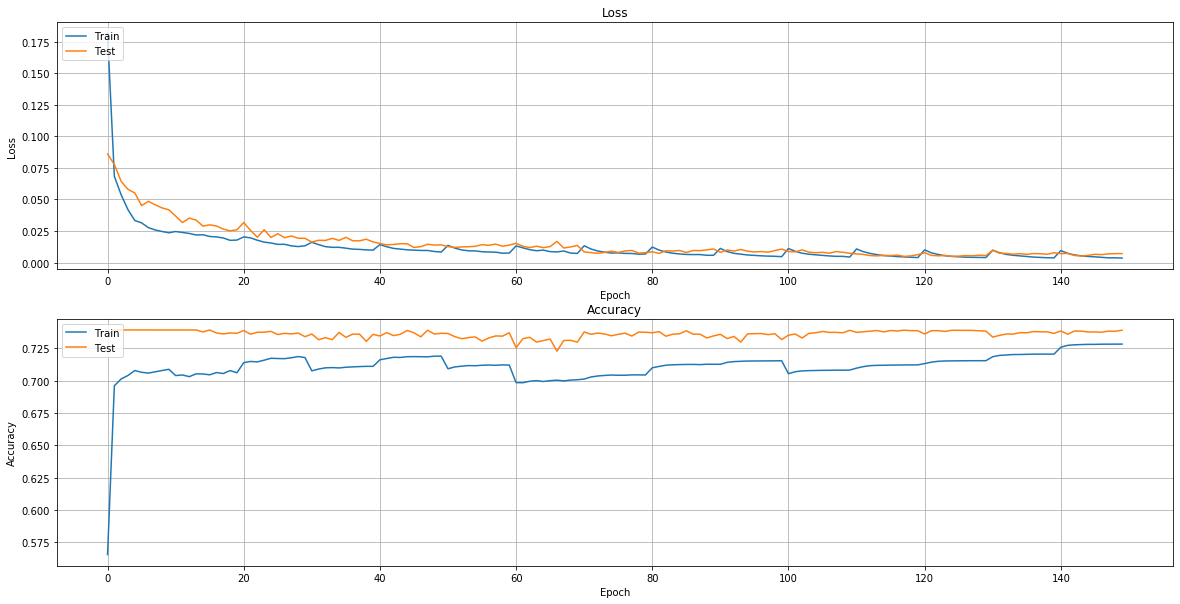

In [7]:
plots.plot_history(loss, acc, val_loss, val_acc)

## Predict

### Eval dataset we used while training

No classes detected, will continue without classes!
Using train_x as train_y


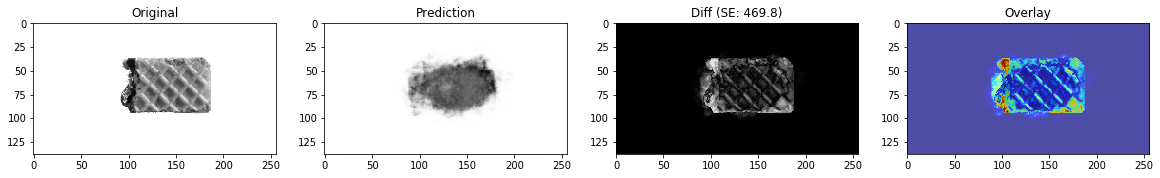

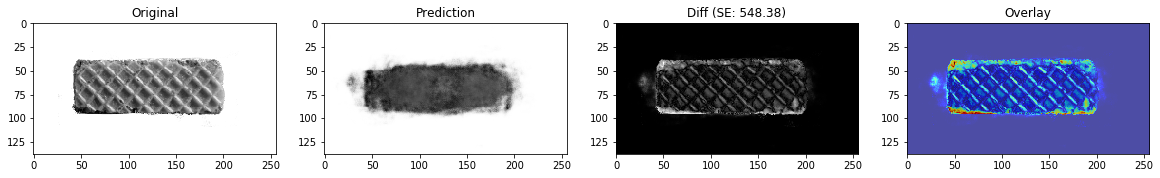

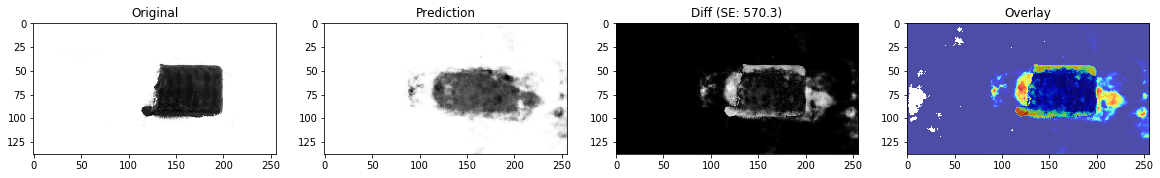

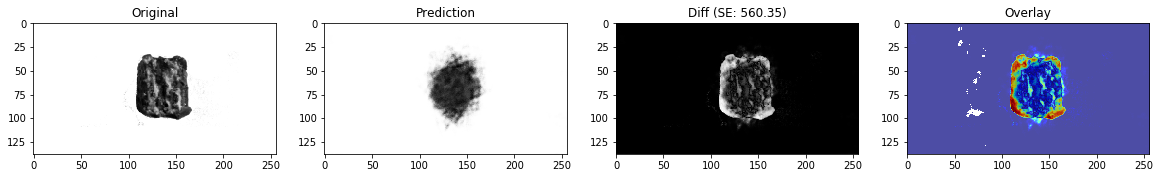

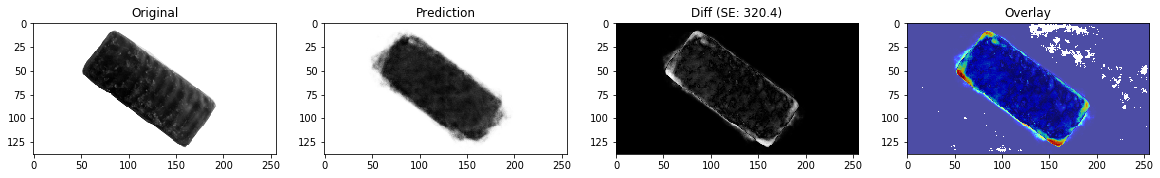

In [8]:
x, _, _, _ = load_dataset(
    eval_files_path, input_shape, validation_split=0
) 

for idx in range(len(x[:5])):
    predictions = train_engine.model.predict(
        np.array([x[idx]], dtype=np.float32), batch_size=1
    )
    plots.plot_difference(predictions, [x[idx]], input_shape)

As we can see, the bad parts have a much higher squared error (SE) as the good one.
Our training images didn't contain any rotated sample, but the network could still easily reconstruct it with a small error rate.

## Cleanup

In [9]:
K.clear_session()